# Time Domain Sonar Lab



In this project, we will interact with physical time-domain signals. 
The first part will involve generating and recording sounds on your computer. We will use the chirp signal to characterize the response of the speaker-microphone acounstic system and detect signals using cross-correlation.
In the second part, we will build on part one and use the computer sound system to develop a simple sonar.

In [1]:
# Import functions and libraries
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import bokeh.plotting as bk
import threading,time, Queue, pyaudio
from matplotlib.pyplot import *
import matplotlib.cm as cm
from scipy import signal
from numpy import *
from bokeh.models import GlyphRenderer
from threading import Lock
bk.output_notebook()
%matplotlib inline

Loading BokehJS ...

## Part 1: Chirping!

For this assignment you will have to use iPython, and a laptop equipped with a speaker and a microphone. When playing a sound and recording on the computer speaker, the signal goes through several systems. In particular it goes through the response of the speaker, the room we are in and the response of the microphone recording system.

A chirp is a a signal in which the frequency increases linearly with time. In this assignment we will generate a chirp signal and use it to measure the amplitude of the frequency response of our speaker-room-microphone system.

A simultaneous frequency is defined as the derivative of the phase of a signal, $f = \frac{1}{2\pi} \frac{d\phi (t)}{ dt} $. For example, the simultaneous frequency of $\cos(\phi(t))=\cos(2\pi f_0 t)$ is  

$$f = \frac{d\phi (t)}{2\pi dt}  = f_0$$ 


For a linear chirp, the frequency changes linearly over time. The simultaneous frequency is therefore defined as 

<center>$$ f(t) = f_0 + kt. $$</center>


So,  

<center>$$ x(t) = \sin(2\pi\int_0^t f(t')dt') = \sin(2\pi\int_o^t(f_0+kt')dt') = \sin(2\pi(f_0+\frac{k}{2}t)t) $$</center>


### Part I Task I: Generating the Chirp

Generate a 15 seconds long chirp signal, sampled at 44,100[Hz] with a frequency range of 20[Hz] to 20000[Hz]. Set the magnitude of the chirp to 0.5. This will help prevent non-linearities when we play the sound later. 


* Set the sample-rate frequency `fs = 44100` Hz
* Generate a time index from `t=0` to `t=15` with sampling rate of 44100 Hz
* Generate a vector of frequency vs time: `f_of_t`  (  $f(t)$ ) that changes linearly from 20Hz to 20Khz over 15 seconds
* Generate a vector of phase vs time: `phi_of_t` (  $\phi(t) = 2\pi \int_0^t f(t)dt$  ) by numerically integrating f_of_t. You will find the function `np.cumsum` useful.
* Generate the chirp function `s_chirp` with amplitude of 0.5
  
  


In [2]:
fs = 44100
f0 = 20.0
f1 = 20000.0
T = 10.0
# your code here
# generate time index
t=np.linspace(0,15,15*fs)
f_of_t = linspace(f0, f1, 15*fs)
# generate phi_of_t
phi_of_t = 2*np.pi*np.cumsum(f_of_t)/fs
# generate chirp signal
s_chirp = 0.5*np.sin(phi_of_t)

* Plot the first $\frac{1}{2}$ a second of the chirp (`s_chirp`), you will notice that the carrier frequency increases and that the chirp has a constant envelope. To get a nice figure, make sure the aspect ratio of the figure is height/width = 0.2. Label the axis and figure appropriately. 

Text(0.5,1,'Chirp signal')

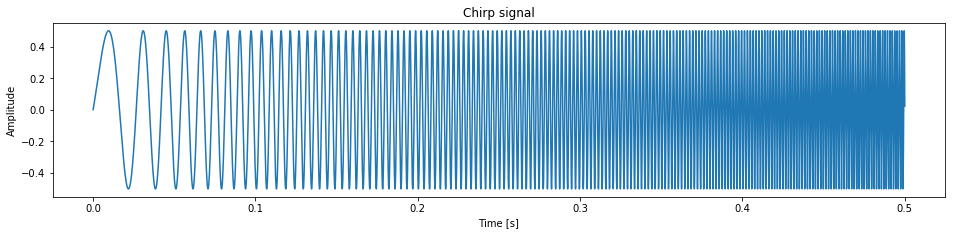

In [3]:
# Set the aspect ratio such that the image is wide
width, height = figaspect(0.2)
fig = figure(figsize=(width,height))

plt.plot(t[t<0.5], s_chirp[t<0.5])
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Chirp signal")

* Plot the magnitude frequency response of the sequence from 0 to $\pi$ using the function `signal.freqz`. Note, that the digital frequency range represents a physical frequency range of 0[hz] to 22050[Hz]. To get a nice figure, make sure the aspect ratio of the figure is height/width = 0.2. Label the axis and figure appropriately.


Text(0.5,1,'Frequency response of chirp signal')

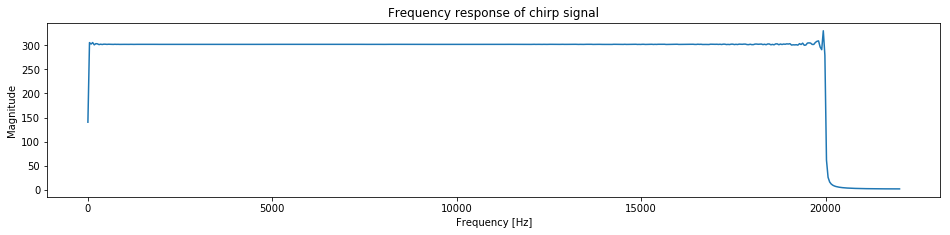

In [4]:
# your code here
# generate frequency response of chirp (use freqz)
f, S_chirp=signal.freqz(s_chirp)

# generate frequency index

f *=fs/np.pi/2
# plot
width, height = plt.figaspect(0.2)
fig = plt.figure(figsize=(width,height))
plt.plot(f, abs(S_chirp))
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.title("Frequency response of chirp signal")

#### Think about why the chirp is an appropriate signal to measure the magnitude frequency response of a system. 
A linear chirp sweeps all frequencies within its bandwidth. The definition of a frequency response is the response of a system to a constant frequency input. If the chirp is slow enough, then it could be considered to be a series of constant frequency inputs. By measuring the resulting (approximately) constant frequency outputs, we can obtain the system's frequency response!

* * *

### Part I Task II: Playing and Recording the Chirp
Now, we will play the sound of the chirp on our computer speaker and simultaneously record using the microphone. 

* In some Windows system there's ambient noise reduction. Make sure it is turned off. Right click the speaker icon on the right bottom. Select 소리 > 녹음 > 사용한 마이크장치 우클릭>속성 > 개선 기능( 있으면 ) > 모든 사운드효과 사용 안함. On Apple computers it is recommended that you turn off the ambient noise reduction by going to system-preferences, selecting sound, choose the input tab and make sure that the "Use ambient noise reduction" box is unchecked.

* Your laptop most likely has two speakers. It is best if we work only with one. Go to the operating system's sound settings and change the stereo settings such that the speaker that is closest to the microphone is active. Your result will be much better that way.
소리>재생> 스피커장치 우클릭> 속성 > 수준 > 밸런스 > L 100, R 0으로 설정
		
* Make sure your output volume is at 70-80% and that the laptop's microphone is on, again to avoid non-linear distorsions. 

* We will record 12 seconds just to make sure we capture the entire sequence. 

The code below defines some functions to use with pyaudio -- a multi-platform audio python interface. 

In [5]:
#This code to play and record sound is provided, no nodification
def play_audio( Q, p, fs , dev=None):
    # play_audio plays audio with sampling rate = fs
    # Q - A queue object from which to play
    # p   - pyAudio object
    # fs  - sampling rate
    # dev - device number
    
    # Example:
    # fs = 44100
    # p = pyaudio.PyAudio() #instantiate PyAudio
    # Q = Queue.queue()
    # Q.put(data)
    # Q.put("EOT") # when function gets EOT it will quit
    # play_audio( Q, p, fs,1 ) # play audio
    # p.terminate() # terminate pyAudio
    
    # open output stream
    ostream = p.open(format=pyaudio.paFloat32, channels=1, rate=int(fs),output=True,output_device_index=dev)
    # play audio
    while (1):
        data = Q.get()
        if data is "EOT" :
            break
        try:
            ostream.write( data.astype(np.float32).tostring() )
        except:
            break
            
def record_audio( queue, p, fs ,dev=None,chunk=1024,lock=None):
    # record_audio records audio with sampling rate = fs
    # queue - output data queue
    # p     - pyAudio object
    # fs    - sampling rate
    # dev   - device number
    # chunk - chunks of samples at a time default 1024
    #
    # Example:
    # fs = 44100
    # Q = Queue.queue()
    # p = pyaudio.PyAudio() #instantiate PyAudio
    # record_audio( Q, p, fs, 1) #
    # p.terminate() # terminate pyAudio
    
    istream = p.open(format=pyaudio.paFloat32, channels=1, rate=int(fs),input=True,input_device_index=dev,frames_per_buffer=chunk)

    # record audio in chunks and append to frames
    frames = [];
    while (1):
        try:  # when the pyaudio object is destroyed, stops
            with lock if lock is not None else 1:
                data_str = istream.read(chunk) # read a chunk of data
        except:
            break
        data_flt = np.fromstring( data_str, 'float32' ) # convert string to float
        queue.put( data_flt ) # append to list

def xciever(sig, fs):
    # function takes a signal and a sampling frequency
    # it then plays and records at the same time. The function returns
    # the recorded sound.

    rcv = [];

    # create an input output FIFO queues
    Qin = Queue.Queue()
    Qout = Queue.Queue()

    #lock for controlling access to shared resources
    lock = Lock()
    
    # create a pyaudio object
    p = pyaudio.PyAudio()

    # initialize a recording thread.
    t_rec = threading.Thread(target = record_audio,   args = (Qin, p, fs ), kwargs={'lock': lock})
    t_play_audio = threading.Thread(target = play_audio,  args = (Qout, p, fs  ))

    # start the recording and playing threads
    t_rec.start()
    t_play_audio.start()

    Qout.put( sig );
    Qout.put( "EOT" );

    # pause for RECORD_SECS seconds
    RECORD_SECS = len(sig)/fs + 2.0
    time.sleep( RECORD_SECS )

    # terminate pyAudio
    with lock:
        p.terminate()
        
    # append to output
    while ( not Qin.empty()) :
        data = Qin.get()
        rcv = np.append( rcv, data )

    return rcv

__Playing and recording audio:__

* Run the following code. It is an example of how to play and record sound at the same time and uses threading for the play and record threads.

The resulting received sequence will be stored in the variable `rcv_chirp`.

In [6]:
## Play and record chirp at the same time
fs = 44100 # sampling rate = 44100 Hz

rcv_chirp = xciever( s_chirp, fs)


D:\util\Anaconda2\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


* Plot the frequency response of the received sequence. 
* Also, plot the absolute value of the received signal. Plotting the absolute value (sort of) displays the envelope of the chirp. 

Label the figures and use an aspect ratio of Height/Width = 0.2


Text(0.5,0,'Time [s]')

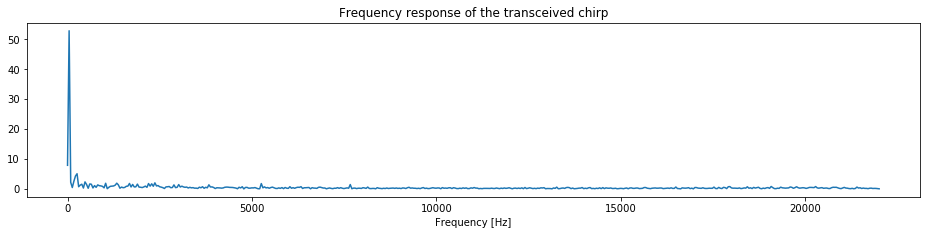

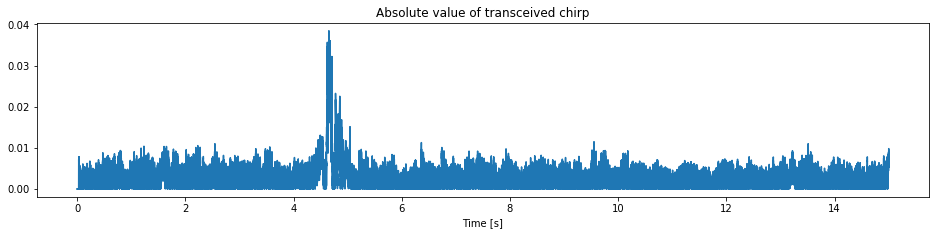

In [7]:
## plot chirp response

# generate frequency response of chirp
f, RCV_chirp=signal.freqz(rcv_chirp)

# generate frequency indices
f *=fs/np.pi/2

# generate time indices
t=np.linspace(0, 15, len(rcv_chirp))

# plot
width, height = figaspect(0.2)
fig = figure(figsize=(width,height))
plt.plot(f, abs(RCV_chirp))
plt.title("Frequency response of the transceived chirp")
plt.xlabel("Frequency [Hz]")

fig = figure(figsize=(width,height))
plt.plot(t, abs(rcv_chirp))
plt.title("Absolute value of transceived chirp");
plt.xlabel("Time [s]")

### Think about the results you got. In addition, what is the implicit assumption we are making in order to claim that the result is a frequency response? 
(HINT: consider the case when the chirp was very short)

What is interesting is that the time response of the chirp is similar to the frequency response. This makes perfect sense, since for a chirp, frequency is dependent on time. The implicit assumption that we are making is that the time effects in the room are much faster than the sweep of the chirp, so for each frequency we get the approximate steady-state response. If the chirp was much faster, we would have seen echoes coming back from reflecting surfaces, which will show up at different times. Then the DTFT of the transceived chirp would include these echoes, thus interfering with the frequency response estimate.

### Part I, Task III: Envelope detection with Hilbert transform. 
The absolute value of the of the result "sort of" displays the envelope, however it is still modulated by the (now rectified) frequency sweep carrier. If we write down the response, it can be expressed approximately as 

$$y[n] = |H[n]| \sin(2\pi (f_0 +k[n*T])nT + \angle H[n])$$

where $|H[n]|$ is the frequency response for the instantaneous frequency at the nth sample and $\angle H[n]$ is its phase response. 

The reason that it is only an approximation is that there is an inherent assumption that we do not look at transient effects, only steady state effect for each frequency. This is a good approximation because our chirp is very slow compared to the propagation of sound in the room. 

One way to get the envelope $|H[n]|$ is to convert it to its analytic signal. The analytic signal $x_a(t)$ of signal $x(t)$ is:

$$x_a = F^{-1}(F(x)\cdot 2U) = x + j y$$

where $F$ is the Fourier transform, $U$ the unit step function,
and $y$ the Hilbert transform of $x$. In other words, the negative half of the frequency spectrum is zeroed
out, turning the real-valued signal into a complex signal.

The analytic signal of the received chirp will then be: 

$$ y_a[n] = |H[n]|e^{j2\pi (f_0 +k[n*T])nT + \angle H[n]} $$

The envelope can be detected by taking the magnitude. 


* Compute the analytic signal by using the function `signal.hilbert` and plot its absolute value. Note that the discrete hilbert transform is not perfect, since it uses FIR filtering. This will show up as ripple in the envelope.

* Label the figures and use an aspect ration of Height/Width = 0.2

Text(0.5,1,'Envelope of the transcieved chirp')

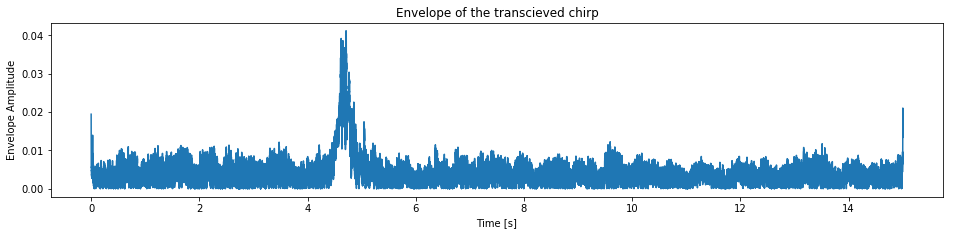

In [8]:
# your lovely code here:
rcv_chirp_a = signal.hilbert(rcv_chirp)

# plot
width, height = figaspect(0.2)
fig = figure(figsize=(width,height))
plt.plot(t, abs(rcv_chirp_a))
plt.xlabel("Time [s]")
plt.ylabel("Envelope Amplitude")
plt.title("Envelope of the transcieved chirp")



### Part I, Task IV: Auto-correlation Properties of the Chirp:

In part II of the lab, we will be sending and receiving chirp pulses to estimate delays between the tranceived pulses. This is done by cross correlating / matched filtering the received signal with the known chirp pulse to detect the echoes. In this task, we will investigate the correlation properties of the chirp.

A cross correlation is defined as:

$$ R_{xy}[n] = \sum_{m=-\infty}^\infty x[m]y^*[m-n] = (x[m]*y^*[-m])[n]$$

which is like a convolution, without flipping one of the signals. It can be implemented using a convolution as shown above. In general, the more correlated the two signals is at position $n$, the higher the value will be. That's why it is useful in a sonar system.

Because we will be doing cross-correlations between a chirp pulse and its echoes, it is useful to look at the auto-correlation, which is basically a cross correlation of the signal with itself. A discrete autocorrelation of a signal is defined as: 

$$ R_{xx}[n] = \sum_{m=-\infty}^\infty x[m]x^*[m-n] = (x[m]*x^*[-m])[n]$$ 

The chirp has a very nice property that its auto-correlation is very narrow. Since the spread of the resulting correlation determines how fast you can detect, the width of the auto-correlation is important. This property is called pulse compression and is widely considered in radar design. Random noise and some other pseudo-random like sequences also possess this property. 

* Generate a 512 sample chirp pulse with a frequency sweep from 17KHz-18KHz and sampling rate fs=44100. 
* Validate its frequency response by plotting it.

Text(0.5,1,'Frequency response of chirp')

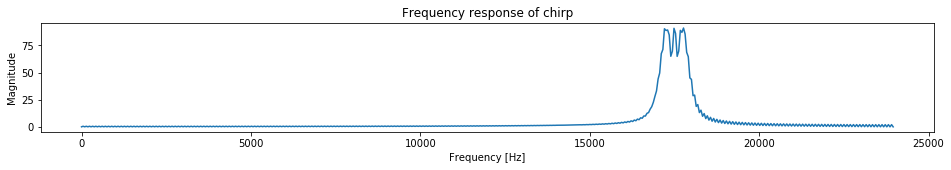

In [9]:
# your beautiful code here:
fs = 48000
N = 512
T = N/fs
t = r_[0.0:N]/fs
f0 = 17000
f1 = 18000

# generate chirp signal
f_of_t = linspace(f0, f1, len(t))
phi_of_t =  2*np.pi*np.cumsum(f_of_t)/fs
s_chirp = np.sin(phi_of_t)

# generate frequency response of chirp
f, S_chirp = signal.freqz(s_chirp)
# generate frequency index
f *=fs/np.pi/2

# plot
width, height = figaspect(0.1)
fig = figure(figsize=(width,height))
plt.plot(f, abs(S_chirp))
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.title("Frequency response of chirp")

* Compute the autocorrelation of the chirp discrete convolution, either with `signal.convolve` or `signal.fftconvolve`. Remember that you have to flip the signal since convolution does that already. You can flip a signal `x` by doing `x[::-1]`. Use mode=''full'' for convolution.
* Plot the autocorrelation. Your plot should be spiky because we did not do envolope detection yet. Use miliseconds as the x-axis

Text(0.5,1,'Autocorrelation of chirp')

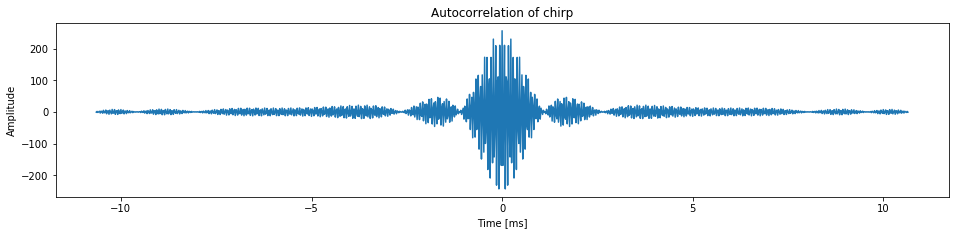

In [10]:
# your fantastic code here:
s_chirp_flip = s_chirp[::-1]
# compute autocorrelation
chirp_acorr = signal.convolve(s_chirp, s_chirp_flip, mode= 'full')
t_flip = np.delete((-1)*t[::-1], -1)
t = np.r_[t_flip, t]*1000
# plot
width, height = figaspect(0.2)
fig = figure(figsize=(width,height))
plt.plot(t, chirp_acorr)
plt.xlabel("Time [ms]")
plt.ylabel("Amplitude")
plt.title("Autocorrelation of chirp")





In a similar way as we did before, it is possible to recover the envelope of the autocorrelation by performing a cross-correlation with the analytic signal and then taking the absolute value. In this case, we know exactly what is the analytic function is!

* Generate `s_chirp_a`, the analytic function of the chirp by computing: `s_chirp_a = exp(1j* phi_of_t )`. Perform cross correlation between `s_chirp_a` and `s_chirp` and show the envelope. This is also called a matched filter. 

Use miliseconds as the x-axis



<IPython.core.display.Javascript object>


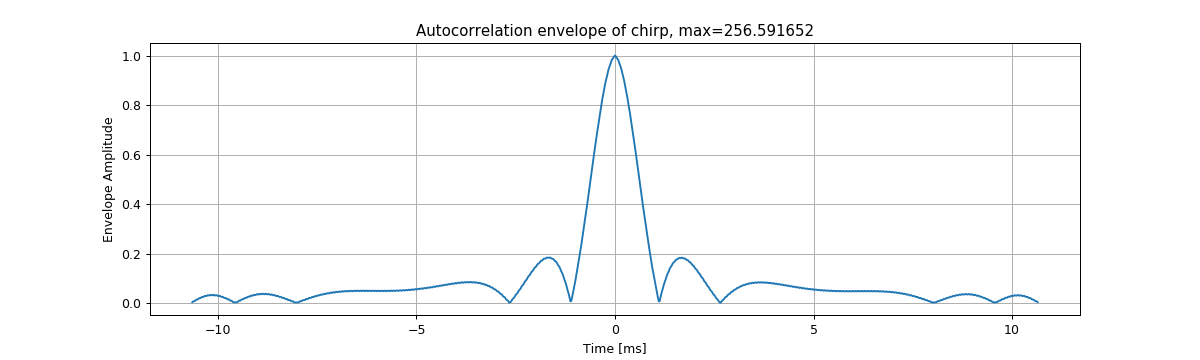

In [12]:
%matplotlib notebook
%matplotlib notebook

# your nice script to produce beautiful chirps, cross-correlations, and figures here:
s_chirp_a = exp(1j* phi_of_t )
# compute autocorrelation and envelope
chirp_acorr = signal.convolve(s_chirp, s_chirp_a[::-1], mode= 'full')
#chirp_acorr = signal.hilbert(abs(chirp_acorr))  ???
max_chirp_acorr = real(max(abs(chirp_acorr)))
tt = t
# plot
width, height = figaspect(0.3)
fig = figure(figsize=(width,height))
plt.plot(tt, abs(chirp_acorr)/max_chirp_acorr)
plt.xlabel("Time [ms]")
plt.ylabel("Envelope Amplitude")
plt.title("Autocorrelation envelope of chirp, max=%f" %max_chirp_acorr)
plt.grid(True)



### Think about the size of the main lobe (full-width at half max) of the matched-filter with respect to the length of the pulse. That ratio is also called pulse compression. 
The main lobe of the matched filter has a FWHM of ~1.23 ms while the original pulse has a duration of ~10.67 ms. Effectively, the pulse is compressed! Now we will look at why the chirp pulse is better for cross-correlation detection than a pure tone.
___

Now we will look at why the chirp pulse is better for cross-correlation detection than a pure tone.
- Repeat Task III for:
 1. A constant frequency of 17500Hz, 512 samples in length. 
 2. A chirp with a frequency sweep from 17000Hz - 18000Hz, 512 in length. 
 3. A chirp with a frequency sweep from 15500Hz - 19500Hz, 512 in length
- Compare the size of the main lobes (full width at half max). How much "Pulse Compression" are you getting by using a chirps for detection compared to a single frequency pulse?

To easily zoom in to the main lobe, you can use bokeh to plot the autocorrelation:

        fig = bk.figure( title = "autocorrelation", 
                    y_axis_label = "Amplitude", x_axis_label = "t[ms]", 
                    plot_height = 300, plot_width = 800)
        fig.line( t, abs(acorr)/max(abs(acorr)), legend = 'autocorrelation', color = 'blue')
        bk.show(fig)
        
where `acorr` is the auto-correlation result and `t` is the index.

<IPython.core.display.Javascript object>


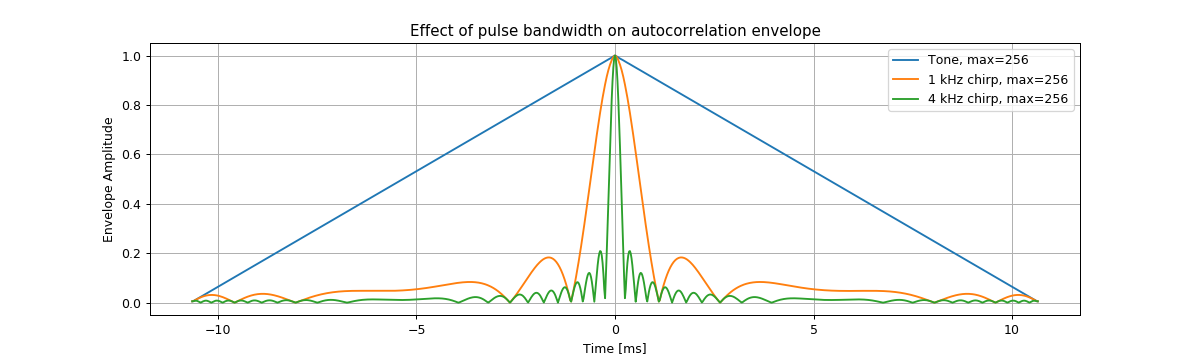

In [13]:
# your brilliant code here:
fs = 48e3
N = 512
T = N/fs
t = r_[0.0:N]/fs

# generate pure tone
f_of_t = linspace(17500, 17500, len(t))
phi_of_t =  2*np.pi*np.cumsum(f_of_t)/fs
s_chirp = np.sin(phi_of_t)
cross_corr_1 = signal.convolve(s_chirp, s_chirp[::-1], mode= 'full')
cross_corr_1 = signal.hilbert(cross_corr_1)

# generate lower bandwidth chirp signal
f_of_t = linspace(17000, 18000, len(t))
phi_of_t =  2*np.pi*np.cumsum(f_of_t)/fs
s_chirp = np.sin(phi_of_t)
cross_corr_2 = signal.convolve(s_chirp, s_chirp[::-1], mode= 'full')
cross_corr_2 = signal.hilbert(cross_corr_2)

# generate higher bandwidth chirp signal
f_of_t = linspace(15500, 19500, len(t))
phi_of_t =  2*np.pi*np.cumsum(f_of_t)/fs
s_chirp = np.sin(phi_of_t)
cross_corr_3 = signal.convolve(s_chirp, s_chirp[::-1], mode= 'full')
cross_corr_3 = signal.hilbert(cross_corr_3)

t_flip = np.delete((-1)*t[::-1], -1)
tt = np.r_[t_flip, t]*1000
# plot
width, height = figaspect(0.3)
fig = figure(figsize=(width,height))
plt.plot(tt, abs(cross_corr_1)/max(abs(cross_corr_1)))
plt.plot(tt, abs(cross_corr_2)/max(abs(cross_corr_2)))
plt.plot(tt, abs(cross_corr_3)/max(abs(cross_corr_3)))
plt.xlabel("Time [ms]")
plt.ylabel("Envelope Amplitude")
plt.title("Effect of pulse bandwidth on autocorrelation envelope")
plt.legend(("Tone, max=%i" %max(abs(cross_corr_1)), "1 kHz chirp, max=%i" %max(abs(cross_corr_2)), "4 kHz chirp, max=%i" %max(abs(cross_corr_3))))
plt.grid(True)



### What is the approximate bandwidth of the pure frequency pulse and what is the bandwidth of the chirp pulses? Comment on the tradeoff between bandwidth and pulse compression

The FWHM of the autocorrelation envelope of the constant frequency signal is ~10.66 ms, the same as its pulse duration. The main lobe for the 1 kHz bandwidth chirp has a FWHM of ~1.23 ms and the 4 kHz chirp has a FWHM of ~0.30 ms. Their pulse compression ratios are ~8.67 and ~35.3, respectively. At the same time, the bandwidth of the constant frequency pulse is approximately 1/(its duration) = ~94 Hz, and the bandwidths of the chirps are 1 kHz and 4 kHz -- these are inversely proportional to the main lobe widths! So, you can't be compact in one domain without expanding in the other...
* * *

- Now, repeat tast III for 
 1. a chirp with a frequency sweep from 16500Hz - 18500Hz, 256 in length

- Compare the size of the main lobe (full width at half max) to the previous case of  15500Hz - 19500Hz, 512 in length.



<IPython.core.display.Javascript object>


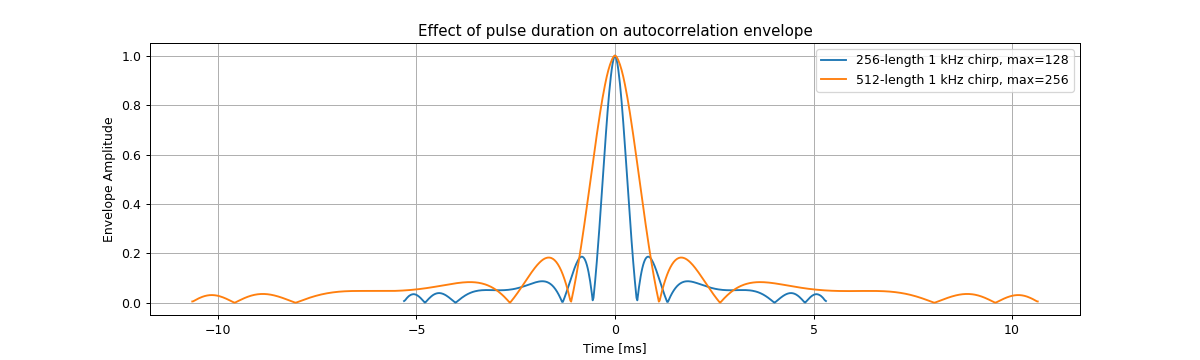

In [14]:
# your amazing code here:
fs = 48000
N = 256
T = N/fs
t = r_[0.0:N]/fs

# generate chirp signal
f_of_t = linspace(16500, 18500, len(t))
phi_of_t =  2*np.pi*np.cumsum(f_of_t)/fs
s_chirp = np.sin(phi_of_t)
cross_corr_4 = signal.convolve(s_chirp, s_chirp[::-1], mode= 'full')
cross_corr_4 = signal.hilbert(cross_corr_4)
t_flip = np.delete((-1)*t[::-1], -1)
tt2 = np.r_[t_flip, t]*1000

# plot
width, height = figaspect(0.3)
fig = figure(figsize=(width,height))
plt.plot(tt2, abs(cross_corr_4)/max(abs(cross_corr_4)))
plt.plot(tt, abs(cross_corr_2)/max(abs(cross_corr_2)))
plt.xlabel("Time [ms]")
plt.ylabel("Envelope Amplitude")
plt.title("Effect of pulse duration on autocorrelation envelope")
plt.legend(("256-length 1 kHz chirp, max=%i" %max(abs(cross_corr_4)), "512-length 1 kHz chirp, max=%i" %max(abs(cross_corr_2))))
plt.grid(True)




#### Dealing with sidelobes
As you can see, the chirp provides good pulse compression of the main-lobe. However, there exists very strong sidelobes. This is because the chirp is multiplied with a rect function, that is abrupt. Instead, we will window the chirp with one of the smooth window functions to taper off the sidelobes. 
    

* Repeat Task 1.4.3 above for a chirp with a sweep from 17KHz to 18KHz, and from 15KHz to 20KHz. This time, multiply the chirp (and its analytic function) with a hanning window.  You will find the function `np.hanning` useful.  What happened to the side-lobes? What happened to the main lobe? What's the tradeoff?

<IPython.core.display.Javascript object>


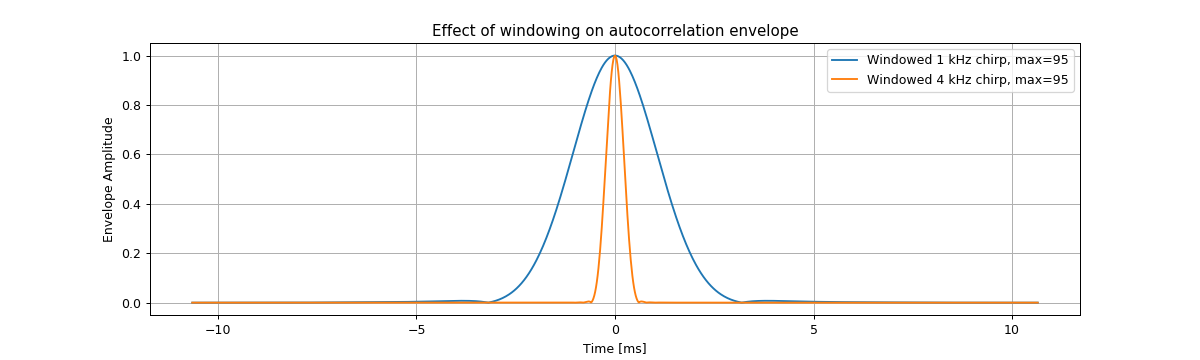

In [15]:
# your code here:
fs = 48000
N = 512
T = N/fs
t = r_[0.0:N]/fs

# generate lower bandwidth chirp signal
f_of_t = linspace(17000, 18000, len(t))
phi_of_t =  2*np.pi*np.cumsum(f_of_t)/fs
s_chirp = np.sin(phi_of_t)
s_chirp = np.multiply(s_chirp,np.hanning(N))
cross_corr_5 = signal.convolve(s_chirp, s_chirp[::-1], mode= 'full')
cross_corr_5 = signal.hilbert(cross_corr_5)

# generate higher bandwidth chirp signal
f_of_t = linspace(15000, 20000, len(t))
phi_of_t =  2*np.pi*np.cumsum(f_of_t)/fs
s_chirp = np.sin(phi_of_t)
s_chirp = np.multiply(s_chirp,np.hanning(N))
cross_corr_6 = signal.convolve(s_chirp, s_chirp[::-1], mode= 'full')
cross_corr_6 = signal.hilbert(cross_corr_6)
t_flip = np.delete((-1)*t[::-1], -1)
tt = np.r_[t_flip, t]*1000

# plot
width, height = figaspect(0.3)
fig = figure(figsize=(width,height))
plt.plot(tt, abs(cross_corr_5)/max(abs(cross_corr_5)))
plt.plot(tt, abs(cross_corr_6)/max(abs(cross_corr_6)))
plt.xlabel("Time [ms]")
plt.ylabel("Envelope Amplitude")
plt.title("Effect of windowing on autocorrelation envelope")
plt.legend(("Windowed 1 kHz chirp, max=%i" %max(abs(cross_corr_5)), "Windowed 4 kHz chirp, max=%i" %max(abs(cross_corr_6))))
plt.grid(True)



### You are now ready to proceed to the Sonar Lab

## Part 2: Sonar

In this part of the lab we will write a simple application that implements a sonar using the laptop internal speaker and microphone. 

The basic idea is very simple and is the basis of sonar and ultrasound images -- Objects reflect sound waves. If we send a pulse of sound, we will get reflection echoes of that pulse. Detecting the echos and their time-of-flight will reveal their distance from the source, based on the speed of sound in air. 

The way we are going to implement the sonar is to generate a series of rapid pulses, and use matched filtering to detect the source and the returning echos. There are many parameters in this lab that can be tweaked to get different results. We encourage you to experiment. We enjoyed very much making the lab and played quite a bit! We hope you enjoy it too. 

Unfortunately, the quallity of the sonar system is going to be highly dependent on your laptop quallity, and the position of the speakers and microphone. It is recommended that you adjust the sound settings on your system such that only the speaker that is closer to the microphone is active. For example, MacBookAirs have the microphone on the side of the computer -- so you should set adjust the audio settings to left speaker only. Also, it is recommended that the speaker volume be set to half of its maximum to avoid non-linear distortions.  

If you are getting poor results, please consult with us. 

This lab was inspired from an iphone app called active-radar. 






### Part II, Task I: Generating Chirp Pulses

First, we will look at short chirp pulses with a pure frequency carrier. These are very common in radar and sonar systems. There are several considerations that we need to make. To be able to detect short distances, and also to be able to get good localization in time our pulses need to be very short. At the same time, shorter pulses carry less energy and have a wider bandwidth (why?). These reduce the signal to noise ratio and reduce our ability to detect targets. At the end, we will have to compromise in order to get satisfactory results in terms of detectibility and resolution. 

We are going to design a pulsed sonar system in which we repeatedly send pulses and then listen to the returning echoes. The arrival time of the echos will correspond to double the distance from a target. 

* Write a function that generates a chirp pulse:
`pulse = genChirpPulse(Npulse, f0, f1, fs)` 

The function will accept: `Npulse` = number of samples, `f0,f1` = starting and ending frequency and `fs` = sampling frequency. The function will return the analytic function of the chirp $\exp (j 2\pi \int_0^t f(t)dt )$ with amplitude 1.

In [16]:
def genChirpPulse(Npulse, f0, f1, fs):
    # Function generates an analytic function of a chirp pulse
    # Inputs:
    #     Npulse = pulse length in samples
    #     f0     = starting frequency of chirp
    #     f1     = end frequency of chirp
    #     fs     = sampling frequency
    # Output:
    #     pulse  = chirp pulse
    
    T = Npulse/fs
    t = np.r_[0.0:Npulse]/fs
    k = (f1-f0)/T
    pulse = exp(1j*2*pi*(f0 + k/2*t)*t)
    
    return pulse


* To validate that the function works display the pulse generated with Npulse = 200, f0=1000, f1 = 8000, fs = 44100. Remember the pulse is complex, so plot the real and imaginary part separately.

Text(0,0.5,'Amplitude')

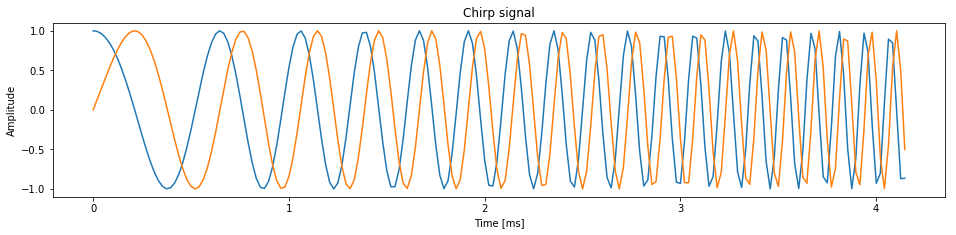

In [17]:
%matplotlib inline
%matplotlib inline

# your code here:
pulse = genChirpPulse(200, 1000.0, 8000.0, 48000.0)
t = r_[0.0:len(pulse)]/fs * 1e3

# plot
width, height = figaspect(0.2)
fig = figure(figsize=(width,height))
plt.plot(t, pulse.real)
plt.plot(t, pulse.imag)
plt.title("Chirp signal")
plt.xlabel("Time [ms]")
plt.ylabel("Amplitude")

__Generate Pulse Trains__

Next, we will use the pulse generated by `genChirpPulse` and generate a pulse train.

* Write a new function `ptrain = genPulseTrain(pulse, Nrep, Nseg)`
The function accepts `pulse` = a pulse generated by `genChirpPulse`,  `Nrep` = number of pulse repetitions and `Nseg` = length of each pulse train segment (which is >= to the length of `pulse`).

The function returns `ptrain` which is a vector of length `Nrep` x `Nseg` (Hint: use `np.tile`)

In [18]:
def genPulseTrain(pulse, Nrep, Nseg):
    # Function generates a pulse train from a pulse. 
    # Inputs:
    #     pulse  = the pulse generated by genChirpPulse
    #     Nrep   = number of pulse repetitions
    #     Nseg   = length of pulse segment >= len(pulse)
    # Output:
    #     ptrain = pulse train
    
    seg = zeros(Nseg)
    seg[:len(pulse)] = pulse
    ptrain = tile(seg, Nrep)
    
    return ptrain

### Part II, Task II: Echos in with Chirp pulse train

We now have components to generate pulses, generate a pulse train, play and record it. Lets see what we get!
We will start with very short pulses with a single carrier frequency. Rectangular pulses are difficult for the speaker
to produce as they exhibit discontinuities in the beginning and the end of the pulse. Therefore we will multiply the pulses
with a smooth window. Here, we will use a hanning window.

* Generate a f0=f1=15KHz, Npulse=60 pulse with fs=44100. Window the pulse with a hanning window. This will result in a pulse slightly longer than 1.5ms. You should be able to hear this tone, though most adults above 40 would not.
* Plot the real and imaginary part of the pulse

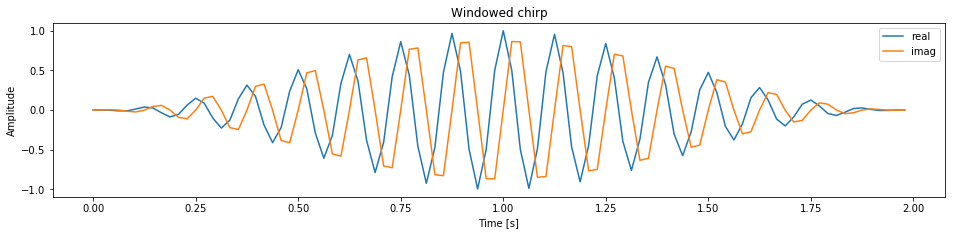

In [19]:
fs = 48000
f0 = 8000
f1 = 8000
Npulse = 96

# your code here:
pulse = genChirpPulse(Npulse, f0, f1, fs)
pulse_a = np.multiply(pulse, np.hanning(Npulse))
pulse=pulse_a.real
t = np.r_[0.0:Npulse]/fs*1000
# plot
width, height = figaspect(0.2)
fig = figure(figsize=(width,height))
plt.plot(t, pulse)
plt.plot(t, pulse_a.imag)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Windowed chirp")
plt.legend(('real','imag'))




* Use the real part of the pulse to generate a pulse train of Nrep=15 pulses, Nseg=4096 samples

In [20]:
# your code here:

ptrain = genPulseTrain(pulse, 15, 4096)

* Play and record the pulse train. Scale the amplitude of the pulses to 1/2. Make sure your volume is set to maximum of 70% and look at the plot with the input pulse train and the received pulse train. A bokeh plot cell is provided so you can zoom in to look at echoes in between.

In [24]:
rcv = xciever(ptrain / 2, fs) 

D:\util\Anaconda2\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


In [25]:
fig = bk.figure( title = "Tranceived pulse train", 
                y_axis_label = "Amplitude", x_axis_label = "Index", 
                plot_height = 300, plot_width = 800)
fig.line( r_[:len(ptrain):10], ptrain[::10], legend = 'transmited', color = 'orange')
fig.line( r_[:len(rcv):10], rcv[::10], legend = 'received', color = 'blue')
bk.show(fig)

* Extract a single pulse from the received pulse train. You can find the pulse index either automatically using a threshold test followed by `np.nonzero` or manually using the `bokeh` plot cell above. Extract at least 2 Npulse samples before the pulse and 20 Npulse samples after using `rcv_pulse = rcv[idx-2*Npulse:idx+Npulse*20]` 

* Plot the received pulse. Can you see any echoes?



<IPython.core.display.Javascript object>


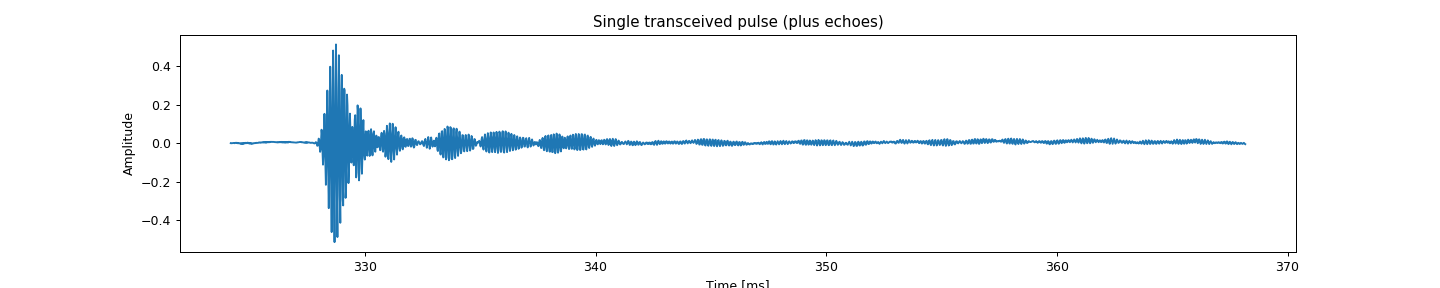

Text(0.5,1,'Single transceived pulse (plus echoes)')

In [26]:
%matplotlib notebook
%matplotlib notebook
# your code here:
idx = np.where(abs(rcv)>0.1)[0][0]
# find index of start pulse
low_idx = idx-2*Npulse
high_idx = idx+Npulse*20
rcv_pulse = rcv[low_idx: high_idx]
t = np.r_[0.0:(15*4096)]/fs*1000
# plot
width, height = figaspect(0.2)
fig = figure(figsize=(width,height))
plt.plot(t[low_idx: high_idx], rcv_pulse)
plt.xlabel("Time [ms]")
plt.ylabel("Amplitude")
plt.title("Single transceived pulse (plus echoes)")



#### Matched Filtering

The strong pulses we see are a result of direct feed-through from the transmitter to the receiver that does not scatter off targets. The echoes we see are a result of echoes from reflecting surfaces. The problem in our setup is that we don't know the exact delay between the transmitter and the receive hardware (in PyAudio). Instead, we will assume that the travel time for sound between the speaker and the microphone is negligible and much smaller than scatering targets. We can then detect when the pulses start based on the direct feedthrough signal. 

We will detect both the feedthrough and echoes using matched filtering. 

* Write a function `Xrcv = crossCorr( rcv, pulse_a )` to calculate the cross correlation (matched filter) of the received signal with the analytic function of the pulse.  You can use `signal.fftconvolve`
* Take the absolute value of `Xrcv` to recover its envelope. Call the result `Xrcv_a`.

In [27]:
def crossCorr(rcv, pulse_a):
    # Funtion generates cross-correlation between rcv and pulse_a.
    # Inputs:
    #     rcv     = received signal
    #     pulse_a = analytic pulse
    # Output:
    #     Xrcv    = cross-correlation between rcv and pulse_a
    
    Xrcv = signal.convolve(rcv, pulse_a[::-1])
    
    return Xrcv

In [28]:
Xrcv_a = abs( crossCorr(rcv, pulse_a) )

fig = bk.figure( title = "Matched filtered signal", 
                y_axis_label = "Amplitude", x_axis_label = "Index", 
                plot_height = 300, plot_width = 800)
fig.line( r_[:len(Xrcv_a):10], Xrcv_a[::10], legend = 'received', color = 'blue')
bk.show(fig)

* Again, extract a single pulse from the received pulse train using the same index. Extract at least 2 Npulse samples before the pulse and 20 Npulse samples after. Plot the received pulse. Can you see any echoes?

<IPython.core.display.Javascript object>


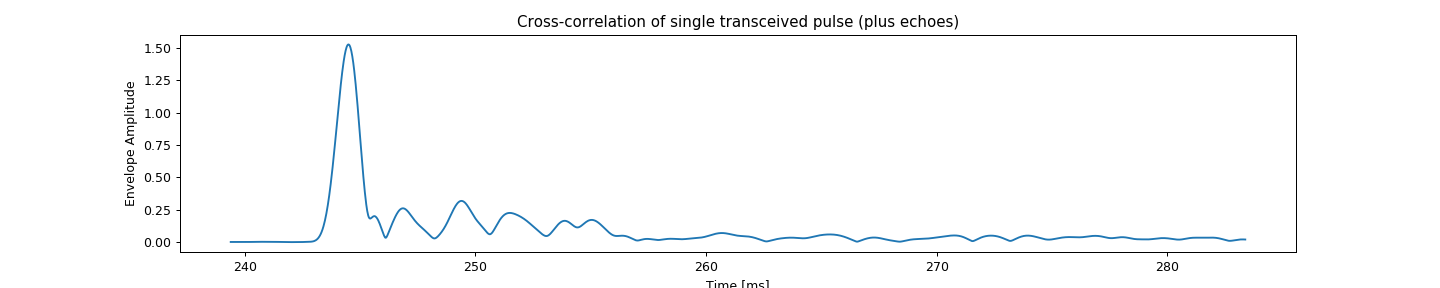

Text(0.5,1,'Cross-correlation of single transceived pulse (plus echoes)')

In [29]:
#Your code here
# find index of start pulse
idx = np.where(abs(Xrcv_a)>0.1)[0][0]
# find index of start pulse
low_idx = idx-2*Npulse
high_idx = idx+Npulse*20
Xrcv_pulse = Xrcv_a[low_idx: high_idx]
t = np.r_[0.0:(15*4096)]/fs*1000

# plot
width, height = figaspect(0.2)
fig = figure(figsize=(width,height))
plt.plot(t[low_idx: high_idx], Xrcv_pulse)
plt.xlabel("Time [ms]")
plt.ylabel("Envelope Amplitude")
plt.title("Cross-correlation of single transceived pulse (plus echoes)")



#### Sonar System

In order to automate the system and visualize the results we need a few more components. To extract the pulses we need to know the position of the first feedthrough pulse. 


* Write a function `idx = findDelay(Xrcv_a, Nseg)` that takes the result of the matched filtering and finds the index of the first feedthrough pulse. Try testing on the actual signal to check whether the function is correct. There are multiple ways of doing it. `Nseg` is not required.

In [30]:
def findDelay(Xrcv, Nseg):
    # Function finds the first pulse index.
    # Inputs:  
    #     Xrcv = the received matched filtered signal
    #     Nseg = length of a segment
    # Output:
    #     ind  = index of the beginning of the first pulse
    
    ind = argmax(Xrcv[0:Nseg])
    
    return ind

In [31]:
Nrep=15
Nseg=4096
ind = findDelay(Xrcv_a, Nseg)
print(ind)

1486


We now can correct for delays and detect echoes. The only thing left now is to convert the time between echoes into actual distance.

If we send a pulse of sound, we will get reflection echoes of that pulse. Detecting the echos and their time-of-flight will reveal their distance from the source, based on the speed of sound in air. The speed of sound in air is given by the following equation:

$$ v_s = 331.5\sqrt{1+T/273.15}~\mathrm{m/s}~,$$ 

where T is the temperature in degree celcius. 

* Create a function `t = dist2time( dist, temperature )` that takes in the distance to the target in cm and converts it into the time in seconds between the transmitted pulse and its echo. Remember the arrival time include the time to the target and back and therefore the time should be doubled. 
For example, for temperature = 20 celcius and dist = 400 cm, the time it takes is 0.023 secs.

In [32]:
def dist2time(dist, temperature=21.0):
    # Function converts distance in cm to time in seconds.
    # Inputs:
    #     dist        = distance to object in cm
    #     temperature = in Celcius
    # Output:
    #     t           = time in seconds between transmitted pulse and echo
    
    #Your code here
    t= dist/331.5/np.sqrt(1+temperature/273.15)/100*2
    
    return t

def  time2dist(t, temperature=21.0):
   #Your code here
    dist = t*331.5*np.sqrt(1+temperature/273.15)*100/2
    
    return dist


### A Sonar
- The following function will use your functions to generate pulses and display the matched filtering of each pulse as intensity of a horizontal line in an image. If nothing is moving, you will be able to see constant vertical lines representing echoes. If something is moving, you will be able to track the object's distance.

In [33]:
def sortOfASonar(Npulse, f0, f1, fs, Nrep, Nseg):
    pulse_a = genChirpPulse(Npulse, f0, f1, fs) * signal.hann(Npulse)
    pulse = pulse_a.real
    ptrain = genPulseTrain(pulse, Nrep, Nseg)
    rcv = xciever(ptrain / 2, fs) 
    rcv = rcv.reshape((rcv.shape[0],))
    Xrcv_a = abs(crossCorr(rcv, pulse_a))
    
    ind = findDelay(Xrcv_a, Nseg) 
    img = np.zeros((Nrep-1,Nseg))
    img[0,:] = Xrcv_a[ind:ind+Nseg]
    
    # Look for peak in each pulse in the pulse train to avoid drift between transmit and receive
    for n in range(1, Nrep-1):
        ind2 = findDelay(Xrcv_a[ind+Nseg//2:ind+Nseg//2+Nseg], Nseg)
        ind = ind + ind2 + Nseg//2
        img[n,:] = Xrcv_a[ind:ind+Nseg]
    
    return img

Now, use the function above to:

- Generate a pulse train of 100 pulses. Each (Hann windowed) pulse should be length Npulse = 72 samples (1.5 ms) and a constant frequency of 8 kHz. The spacing between pulses should be 0.1 seconds (Nseg = 4800).
- Display the image.

D:\util\Anaconda2\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


<IPython.core.display.Javascript object>


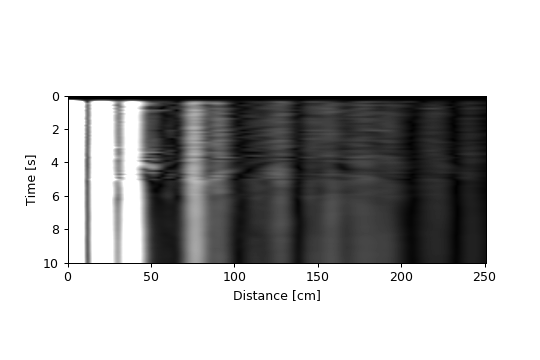

Text(0,0.5,'Time [s]')

In [35]:
Npulse = 72
f0 = 8e3
f1 = 8e3
fs = 48e3
Nrep = 100
Nseg = 4800
img = sortOfASonar(Npulse, f0, f1, fs, Nrep, Nseg)


%matplotlib notebook
%matplotlib notebook

# display up to 2.5 m, approximately 700 samples at 48000 Hz sampling rate (and 21 degrees C)

vmax = 0.25 # threshold -- lower will be able to see smaller echoes

plt.imshow(img[:,0:700]/max(img.ravel()), vmax=vmax, aspect=10, cmap='gray', interpolation='bilinear', extent=(0,time2dist(700/fs), Nrep*Nseg/fs, 0))
plt.xlabel('Distance [cm]')
plt.ylabel('Time [s]')

Feel free to repeat while moving a target -- can you see the echoes changing? Try playing with different parameters, especially the chirp length, Npulse.

You now have a working sonar! It would be much easier though to play with different parameters if we automate things, so we created some wrappers for real-time plotting in a separate notebook (lab1-RealTime-Sonar). 

* Copy-and-paste the 5 functions you created, including genPulseTrain(), genChirpPulse(), crossCorr(), findDelay(), and dist2time(), to the specified code cell in the real-time Sonar lab.


### You are now ready to proceed to the Real-Time Sonar Lab